In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import model
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [3]:
def get_training_data(N):
    X = np.random.uniform(-5, 5, (N,2))
    R = np.sqrt(X[:, 0]**2 + X[:, 1]**2)
    Z = np.sin(R)
    return X, Z

def get_reference():
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    Z = np.sin(R)
    return X, Y, Z

iterations = 30000
N = 128
D_in = 2
H = 256
D_out = 1
learning_rate = 1e-4

In [4]:
use_cuda = torch.cuda.is_available() and True

if not torch.cuda.is_available():
    print('CUDA is not available')
    
#x = Variable(torch.randn(N, D_in))
#y = Variable(torch.randn(N, D_out), requires_grad=False)
#print(x)
#print(y)

def get_model(loss_obj):
    model = torch.nn.Sequential(
                nn.Linear(D_in, H),
                nn.ReLU(),
                nn.Linear(H, H),
                nn.ReLU(),    
                nn.Linear(H, D_out),
            )
    
    if use_cuda:
        model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    return (model, loss_obj, optimizer)

In [5]:
diffs = {
    'symm': [],
    'underest': [],
    'overest': []
}

for _ in range(3):
    models = {
        'symm': get_model(nn.MSELoss()),
        'underest': get_model(losses.linex_underestimate),
        'overest': get_model(losses.linex_overestimate)
    }
    
    x_train, y_train = get_training_data(N*iterations)
    x_val, y_val = get_training_data(1000)
    
    for model_key in models.keys(): # ['overest']
        model, loss_fn, optimizer = models[model_key]

        for i in range(iterations):
            x = Variable(torch.from_numpy(x_train[i*N:(i+1)*N, :]), requires_grad=False).float()
            y = Variable(torch.from_numpy(y_train[i*N:(i+1)*N]), requires_grad=False).float()

            if use_cuda:
                x = x.cuda()
                y = y.cuda()

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            if i % 1000 == 0:
                print(model_key, i, loss.data[0])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Final result
        x = Variable(torch.from_numpy(x_val), requires_grad=False).float()
        y = Variable(torch.from_numpy(y_val), requires_grad=False).float()

        if use_cuda:
            x, y = x.cuda(), y.cuda()

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        print(loss.data[0])
        diffs[model_key].extend(y_pred.cpu().data.numpy()[:,0] - y_val)
    
diffdf = pd.DataFrame.from_dict(diffs)

underest 0 0.44459059834480286
underest 1000 0.05684748291969299
underest 2000 0.005643664859235287
underest 3000 0.00045068375766277313
underest 4000 0.00019905203953385353
underest 5000 0.00013975519686937332
underest 6000 7.228879258036613e-05
underest 7000 6.196973845362663e-05
underest 8000 7.987255230545998e-05
underest 9000 2.8897076845169067e-05
underest 10000 5.2782706916332245e-05
underest 11000 9.693671017885208e-05
underest 12000 4.400685429573059e-05
underest 13000 2.7257949113845825e-05
underest 14000 3.895442932844162e-05
underest 15000 3.3892691135406494e-05
underest 16000 2.7752947062253952e-05
underest 17000 7.237773388624191e-05
underest 18000 2.795085310935974e-05
underest 19000 4.400918260216713e-05
underest 20000 1.4520250260829926e-05
underest 21000 3.026239573955536e-05
underest 22000 3.0001625418663025e-05
underest 23000 2.9049348086118698e-05
underest 24000 1.8580351024866104e-05
underest 25000 9.77320596575737e-05
underest 26000 2.193637192249298e-05
underest

<IPython.core.display.Javascript object>


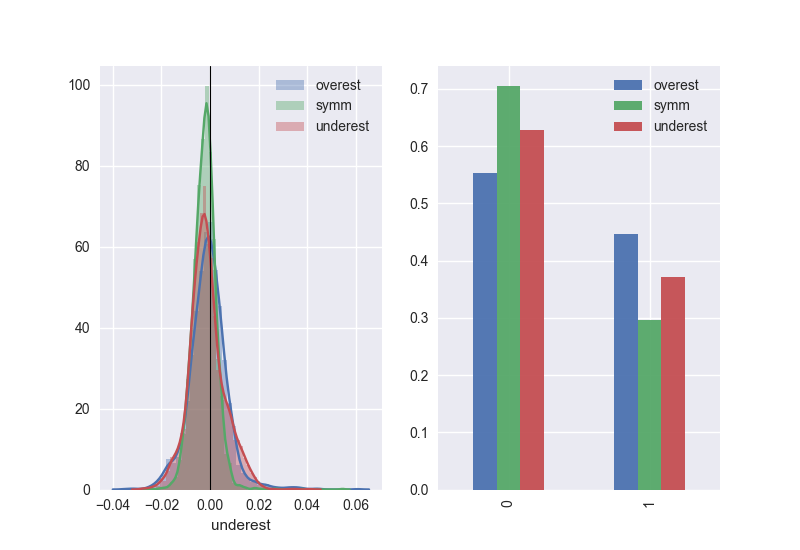

overest 1660 1340
symm 2114 886
underest 1884 1116


In [6]:
fig = plt.figure()
ax = plt.subplot(121)

for key in diffdf.columns:
    print(key, (diffdf[key] < 0).sum(), (diffdf[key] >= 0).sum())
    sns.distplot(diffdf[key], label=key)

plt.axvline(x=0, color='k', linewidth=0.8)    
plt.legend()

ax = plt.subplot(122)
diffdf.apply(lambda x: pd.Series([(x < 0).sum()/x.count(), (x >= 0).sum()/x.count()])).plot.bar(ax=ax, alpha=0.95, sort_columns=True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = get_reference()
X_est, Y_est = np.meshgrid(x_data[:, 0], x_data[:, 1])
ax.plot_surface(X_est, Y_est, y_pred, color='red')
ax.plot_surface(X, Y, Z, color='green')

plt.show()

<IPython.core.display.Javascript object>


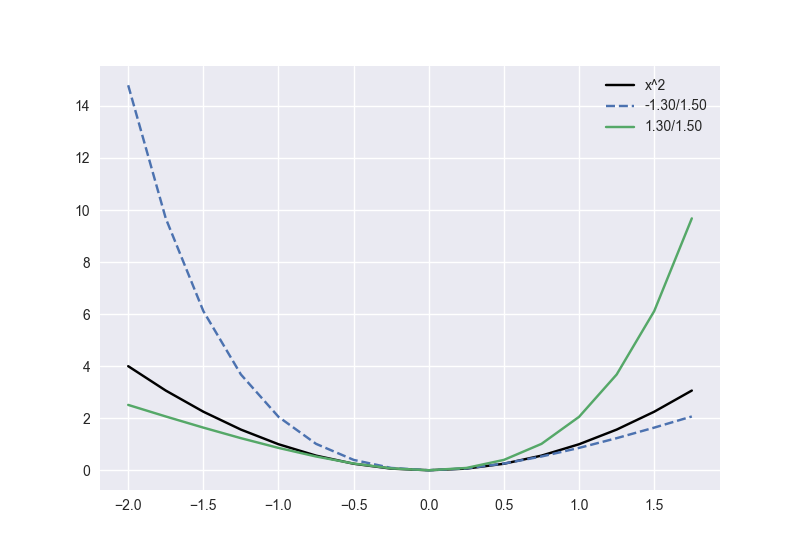

In [7]:
fig = plt.figure()

x = np.arange(-2, 2, 0.25)

plt.plot(x, x**2, color='k', label='x^2')

for a in [-1.3, 1.3]:
    for b in [1.5]:
        y = b * (np.exp(a * x) - a * x - 1)
        plt.plot(x, y, label='%.2f/%.2f' % (a, b), linestyle='--' if a < 0 else '-')

plt.legend()
plt.show()